# This is The Title of Notebook
### Purpose
In this notebook I will create an example header and show how to structure the notebooks for easy readaility and documentation. 

In short, we are trying to follow the conventions of Cookie Cutter Data Science: https://drivendata.github.io/cookiecutter-data-science/ 

#Temperature Accuracy Analysts
 
 * [ ] How many circles are between the temp min and temp max of a noaa station? How many are not?
 * [ ] Plots of Temperature NOAA, Temperature circle as a function of time for some circles
 * [ ] Plot (T_NOAA-T_circle)
 * [ ] Temperature Measurement Goodness with Interchangeable Metric
   
   ----- Example Metric. Will says we should consider something like dT=sqrt( (T_N,min-TC,min)^2+(T_N,max-TC_max)^2). -- This would be a measure of how far off the NOAA data and Circle data differ.  The squares are because we care about magnitude of difference, not sign of difference. Then we define a range that we will say is "good". Example If dT< 5 we mark the circle as good for that year
   ---- plot these on a map with the outliers in one color and the good stations in another color to see if there is any geographic clustering for "good" vs "bad"
   ---- _**Note on Building the Notebook**_  Will believes that the best thing we can do for audubon is to pass them a notebook to allow them to easily define the metrics and range on if the Temperature for each circle is within an defined metric. So when we do this analysis and build our metrics and ranges, we should construct the notebook such that it is easy for us and Audubon to switch out these values. Pretty similar to how we define static variables at the top  of our notebooks for file names.
   
 * [ ]  Provide an opinion to this statement: CBC volunteers are NOT good resources for temperature data.
 * [ ]  Optional: Have Metric and Threshold analysis Breakdown by Ecosystem
 * [ ]  Optional: Have Metric and Threshold analysis Breakdown by set distance threshold
 
 # Deliverable
 * Deliverable for the Audubon society will be a list of circles but we think the data is accurate.
 * FAQ Sections
   ----- What is happening in the 20 - 70 with temp?
 
 ----- Some of the min_temps that have errors look like they are cases where the circle value is listed as 0. Is it possible that this was either a data entry error, or when someone left it blank, it somehow got a zero filled in?
 
 Notes:
 Only use CBC circles that have NOAA stations attached



### Author: 
Jacob Ellena
### Date: 
2020-07-30
### Update Date: 
2020-07-30

### Inputs 
1.3-rec-connecting-fips-ecosystem-data.txt -  
Example
cbc_effort_weather_1900-2018.txt - Tab seperated file of Christmas Bird Count events going back to 1900. Each row represents a single count in a given year. Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

### Output Files
This is where you list any files or artifcats this notebook produces. Please also give a short summary of the data 

DataFiles should be named after the notebook when possible, ie this notebook might produce the file 0.0-rec-example-notebook-with-header.csv 


## Steps or Proceedures in the notebook 
This is where you list what you did in the notebook. The goal is that someone who has never coded in their life can understand what you did. Pro Tip -- if you are working off of an Github issue, this is a great place to put those check boxes! 
- Create an Example Header 
- Create an example of Loading Data 


## Where the Data will Be Saved 
All data for this project will be saved in Google Drive. To start experimenting with data, download the folder hear and put it into your data folder.
https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

The path should look like this: 
audubon-cbc/data/Cloud_Data/<DATA FILE>

In [33]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Options
pd.set_option("display.max_columns", 100)

## This is a Section Header: How to Get Data For the Project
Data for this project is saved in Google Drive. You can start using this data by following the steps below
1. Clone the github repo (which I'm assuming you've done since your reading this)
2. Go to this folder and download it: https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I
3. Paste it into the data folder in your local repository. The path should look like this: audubon-cbc/data/Cloud_Data/
4. Voila! You have data. Lets test it.

In [2]:
# ALL File Paths should be declared at the TOP of the notebook
PATH_TO_RAW_CBC_DATA = "../data/Cloud_Data/1.3-rec-connecting-fips-ecosystem-data.txt"

In [3]:
raw_data = pd.read_csv(PATH_TO_RAW_CBC_DATA, encoding = "ISO-8859-1", sep="\t", compression='gzip')

C:\Users\jacob\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (62,64,65,71,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
raw_data.head()

,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,field_hours,feeder_hours,nocturnal_hours,field_distance,nocturnal_distance,distance_units,min_temp,max_temp,temp_unit,min_wind,max_wind,wind_unit,min_snow,max_snow,snow_unit,am_cloud,pm_cloud,field_distance_imperial,field_distance_metric,nocturnal_distance_imperial,nocturnal_distance_metric,min_snow_imperial,min_snow_metric,max_snow_metric,max_snow_imperial,min_temp_imperial,max_temp_imperial,min_temp_metric,max_temp_metric,min_wind_metric,max_wind_metric,min_wind_imperial,max_wind_imperial,ui,geohash_circle,circle_id,id,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmoid,geohash_station,temp_min_value,temp_max_value,precipitation_value,temp_avg,snow,snwd,am_rain,pm_rain,am_snow,pm_snow,circle_elev,elevation_source,block_fips,county_fips,Ecosys_circle,Usgsid_sys_circle,Nlcd_code_circle,Nlcd_circle,Ecosys_station,Usgsid_sys_station,Nlcd_code_station,Nlcd_station
0,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1955,1955-01-01,11.0,NaN,NaN,NaN,23.0,NaN,NaN,45.0,NaN,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,72.417123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.4333-155.2833_1955,8e3w,8e3wd3w,USC00511303,19.4297,-155.2561,1210.40,HI,HAWAII VOL NP HQ 54,,,NaN,8e3w,100.0,161.0,180.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1228.18,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1956,1955-12-31,11.0,NaN,NaN,NaN,32.0,NaN,NaN,104.0,NaN,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,167.364017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.4333-155.2833_1956,8e3w,8e3wd3w,USC00511303,19.4297,-155.2561,1210.40,HI,HAWAII VOL NP HQ 54,,,NaN,8e3w,117.0,189.0,290.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1228.18,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,14.0,NaN,NaN,62.0,NaN,Miles,54.0,66.0,NaN,3.0,6.0,NaN,0.0,0.0,NaN,2.0,2.0,62.0,99.774702,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,12.222222,18.888889,4.827808,9.655616,1.8642,3.7284,19.4333-155.2833_1968,8e3w,8e3wd3w,US1HIHI0013,19.4391,-155.2156,1059.20,HI,VOLCANO 4.3 SSE,,,NaN,8e3w,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3,3,1228.18,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,14.0,NaN,NaN,62.0,NaN,Miles,54.0,66.0,NaN,3.0,6.0,NaN,0.0,0.0,NaN,2.0,2.0,62.0,99.774702,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,12.222222,18.888889,4.827808,9.655616,1.8642,3.7284,19.4333-155.2833_1968,8e3w,8e3wd3w,US1HIHI0071,19.4414,-155.2487,1194.80,HI,VOLCANO 4.0 S,,,NaN,8e3w,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3,3,1228.18,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,14.0,NaN,NaN,62.0,NaN,Miles,54.0,66.0,NaN,3.0,6.0,NaN,0.0,0.0,NaN,2.0,2.0,62.0,99.774702,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,12.222222,18.888889,4.827808,9.655616,1.8642,3.7284,19.4333-155.2833_1968,8e3w,8e3wd3w,USC00514563,19.4094,-155.2608,1079.87,HI,KILAUEA CAMP,,,NaN,8e3w,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3,3,1228.18,usgs_api,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Pulling out temperature data and renaming columsn for clarification
temp_df_raw = raw_data[['count_year',
                    'circle_name', 
                    'circle_id',
                    'lat',
                    'lon',
                    'min_temp',
                    'max_temp',
                    'id',
                    'latitude',
                    'longitude',
                    'temp_min_value',
                    'temp_max_value']]

#Setting temp_df to be a copy to avoid indexing erros
temp_df = temp_df_raw.copy()

temp_df.rename(columns={
    'lat':'circle_lat',
    'lon':'circle_lon',
    'min_temp':'circle_min_temp',
    'max_temp':'circle_max_temp',
    'temp_unit':'circle_temp_unit',
    'id':'noaa_id',
    'latitude':'noaa_lat',
    'longitude':'noaa_lon',
    'temp_min_value':'noaa_min_temp',
    'temp_max_value':'noaa_max_temp'},
    inplace=True
              )
#Setting number of rows for comparison of how much data is lost after cleaning
row_count = temp_df.shape[0]
temp_df.head()

,circle_name,circle_id,circle_lat,circle_lon,circle_min_temp,circle_max_temp,noaa_id,noaa_lat,noaa_lon,noaa_min_temp,noaa_max_temp
0,Hawai'i: Volcano N.P.,8e3wd3w,19.4333,-155.2833,NaN,NaN,USC00511303,19.4297,-155.2561,100.0,161.0
1,Hawai'i: Volcano N.P.,8e3wd3w,19.4333,-155.2833,NaN,NaN,USC00511303,19.4297,-155.2561,117.0,189.0
2,Hawai'i: Volcano N.P.,8e3wd3w,19.4333,-155.2833,54.0,66.0,US1HIHI0013,19.4391,-155.2156,NaN,NaN
3,Hawai'i: Volcano N.P.,8e3wd3w,19.4333,-155.2833,54.0,66.0,US1HIHI0071,19.4414,-155.2487,NaN,NaN
4,Hawai'i: Volcano N.P.,8e3wd3w,19.4333,-155.2833,54.0,66.0,USC00514563,19.4094,-155.2608,NaN,NaN


## EDA Notes
In order to compare temperature between CBC Circles and NOAA Stations several cleaning steps are needed
1. Compare only CBC Circles with NOAA Stations Attached
2. Remove rows with no data for either CBC Circle or NOAA Station
3. Create averages for both Circles and Stations for comparisons

#### EDA Note 1
Checking number of rows without a CBC Circle or NOAA station

In [7]:
print(f" Number of rows without a CBC Circle is:   {temp_df['circle_id'].isna().sum()}")
print(f" Number of rows without a NOAA Station is: {temp_df['noaa_id'].isna().sum()}")

 Number of rows without a CBC Circle is:   0
 Number of rows without a NOAA Station is: 0


#### EDA Note 2
Removing rows without temperature data for either CBC Circles or NOAA stations.

In [8]:
temp_df.dropna(axis=0, subset=['circle_min_temp', 'circle_max_temp', 'noaa_min_temp', 'noaa_max_temp'], inplace=True)
print(f"Number of rows before: {row_count}")
print(f"Number of rows after:  {temp_df.shape[0]}")
print(f"Total removed:         {row_count - temp_df.shape[0]}")

Number of rows before: 756378
Number of rows after:  61777
Total removed:         694601


#### EDA Note 3 
Generating Averages

In [11]:
temp_df['circle_average'] = (temp_df['circle_min_temp'] + temp_df['circle_max_temp'])/2
temp_df['noaa_average'] = (temp_df['noaa_min_temp'] + temp_df['noaa_max_temp'])/2

### Checking to see how many CBC Circle temperatures records are within the bounds of the NOAA Station records

In [13]:
temp_df['temp_check'] = temp_df['circle_average'].between(temp_df['noaa_min_temp'], temp_df['noaa_max_temp'])

In [26]:
# Counting number of circles that are true
temp_true = sum(temp_df['temp_check'])
temp_false = temp_df.shape[0] - sum(temp_df['temp_check'])
print(f"Number of CBC Cirlcs who's temperature is in the bounds of the corresponding NOAA station:     {sum(temp_df['temp_check'])}")
print(f"Number of CBC Cirlcs who's temperature is not in the bounds of the corresponding NOAA station: {temp_df.shape[0] - sum(temp_df['temp_check'])}")
print()
print(f"{round((temp_true/temp_df.shape[0])*100)}% of stations lay between")

Number of CBC Cirlcs who's temperature is in the bounds of the corresponding NOAA station:     28755
Number of CBC Cirlcs who's temperature is not in the bounds of the corresponding NOAA station: 33022

47% of stations lay between


# NEXT STEPS
1. Count circles with highest number of occurances
2. Build function to plot NOAA data to Circle Data over time
3. Do this for top three
4. Build Metric Thingy
5. Figure out how to plot on map

### Plotting out CBC Circle temperature data to NOAA Station data

''

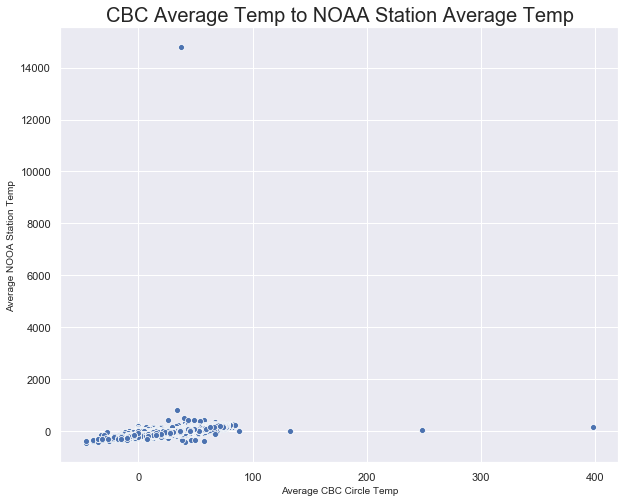

In [46]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=temp_df['circle_average'], y=temp_df['noaa_average'])
plt.title('CBC Average Temp to NOAA Station Average Temp', fontsize=20)
plt.xlabel('Average CBC Circle Temp', fontsize=10)
plt.ylabel('Average NOOA Station Temp', fontsize=10)
;

## Saving Data From a Notebook
If a notebook is used to clean or add to a dataset, the resulting dataset should be named after the notebook that produced it. For example the data produced by this notebook would be called 0.0-rec-example-notebook-with-header.csv 

## Getting your data into Google Drive. 
If you have data you think is ready to be added to the offical google drive data folder, your DA will ask you for the following infomation.

- Number of Rows in the Data
- Discription and name of any new feilds 